# Daylight Saving Effect on Heart Attack

We will use the [healthcare dataset from Kaggle](https://www.kaggle.com/datasets/prasad22/healthcare-dataset).

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dowhy.causal_identifier import backdoor
import networkx as nx
from pgmpy.estimators import PC
from pgmpy.models import BayesianModel
import dowhy
from dowhy import CausalModel
import os
import cdt

from warnings import filterwarnings
filterwarnings('ignore')

from itertools import combinations
# cdt.SETTINGS.rpath = '/usr/lib/R/bin/Rscript' # for macOS
# cdt.SETTINGS.rpath = 'C:\Program Files\R\R-4.3.2\bin\Rscript' # for Windows
from numpy.random import normal
import pingouin as pg

np.random.seed(0)

Detecting 1 CUDA device(s).


# Motivation and Data Processing - 10% of the grade

Motivation, description of dataset and causal questions, description of assumptions, show true causal graph or a reasonable guess (10% grade)

In [2]:
file_path = 'data/healthcare/healthcare_dataset.csv'
df = pd.read_csv(file_path)

Encode the unique medical conditions in the 'Medical Condition' feature into one-hot encoded columns.

In [3]:
print(df['Medical Condition'].value_counts())

df = pd.concat([df, pd.get_dummies(df['Medical Condition'], dtype='int')], axis=1)
df = df.drop(columns='Medical Condition')
df = df.drop(columns=['Asthma', 'Cancer', 'Arthritis', 'Obesity', 'Diabetes'])
df.head()

Medical Condition
Asthma          1708
Cancer          1703
Hypertension    1688
Arthritis       1650
Obesity         1628
Diabetes        1623
Name: count, dtype: int64


,Name,Age,Gender,Blood Type,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results,Hypertension
0,Tiffany Ramirez,81,Female,O-,2022-11-17,Patrick Parker,Wallace-Hamilton,Medicare,37490.983364,146,Elective,2022-12-01,Aspirin,Inconclusive,0
1,Ruben Burns,35,Male,O+,2023-06-01,Diane Jackson,"Burke, Griffin and Cooper",UnitedHealthcare,47304.064845,404,Emergency,2023-06-15,Lipitor,Normal,0
2,Chad Byrd,61,Male,B-,2019-01-09,Paul Baker,Walton LLC,Medicare,36874.896997,292,Emergency,2019-02-08,Lipitor,Normal,0
3,Antonio Frederick,49,Male,B-,2020-05-02,Brian Chandler,Garcia Ltd,Medicare,23303.322092,480,Urgent,2020-05-03,Penicillin,Abnormal,0
4,Mrs. Brandy Flowers,51,Male,O-,2021-07-09,Dustin Griffin,"Jones, Brown and Murray",UnitedHealthcare,18086.344184,477,Urgent,2021-08-02,Paracetamol,Normal,0


Only keep first entry of the same person

In [4]:
filtered_df = df[~df['Name'].duplicated(keep='first')]

Let's see how many unique values each variable has.

In [5]:
for col_name in filtered_df.columns:
    print(f'{col_name}:{filtered_df[col_name].nunique()}')

Name:9378
Age:68
Gender:2
Blood Type:8
Date of Admission:1812
Doctor:8856
Hospital:8144
Insurance Provider:5
Billing Amount:9378
Room Number:400
Admission Type:3
Discharge Date:1832
Medication:5
Test Results:3
Hypertension:2


We decide that the following variables are irrelevant for our analysis or have arbitrary data: ```['Doctor', 'Hospital', 'Room Number', 'Discharge Date']```. We can also drop ```'Name'``` since we already filtered by the first visit of unique individuals.

In [6]:
filtered_df = filtered_df.drop(columns=['Doctor', 'Hospital', 'Room Number', 'Discharge Date', 'Name'])

Let's see the unique values of the columns with less than 10 unique values. We print the column names containing continuous data.

In [7]:
categoricals = []

for col_name in filtered_df.columns:
    if filtered_df[col_name].nunique() <= 10:
        print(f'{col_name}:{filtered_df[col_name].unique()}')
        categoricals.append(col_name)
    else:
        print(f'{col_name} is a continuous variable.')

Age is a continuous variable.
Gender:['Female' 'Male']
Blood Type:['O-' 'O+' 'B-' 'AB+' 'A+' 'AB-' 'A-' 'B+']
Date of Admission is a continuous variable.
Insurance Provider:['Medicare' 'UnitedHealthcare' 'Aetna' 'Cigna' 'Blue Cross']
Billing Amount is a continuous variable.
Admission Type:['Elective' 'Emergency' 'Urgent']
Medication:['Aspirin' 'Lipitor' 'Penicillin' 'Paracetamol' 'Ibuprofen']
Test Results:['Inconclusive' 'Normal' 'Abnormal']
Hypertension:[0 1]


We aim to introduce a binary column: assigning a value of 1 if the admission date falls within a 3-month window surrounding the annual daylight saving time change in March (a period during which individuals typically adjust their schedules due to a one-hour reduction in sleep), and 0 otherwise. Our dataset spans the years 2018-2023, and we construct a dictionary pairing each year with the specific date of the daylight saving time transition.

In [8]:
daylight_saving_dates = {
    2018: '2018-03-25',
    2019: '2019-03-31',
    2020: '2020-03-29',
    2021: '2021-03-28',
    2022: '2022-03-27',
    2023: '2023-03-26'}

In [9]:
daylight_saving_dates = {year: pd.to_datetime(date) for year, date in daylight_saving_dates.items()}

filtered_df['Date of Admission'] = pd.to_datetime(filtered_df['Date of Admission'])

filtered_df['daylight_saving_march'] = filtered_df['Date of Admission'].apply(lambda date: 1 
                                                                        if daylight_saving_dates[date.year] <= date <= daylight_saving_dates[date.year] + pd.DateOffset(days=10)
                                                                        else 0)

filtered_df['daylight_saving_before_march'] = filtered_df['Date of Admission'].apply(lambda date: 1 
                                                                        if daylight_saving_dates[date.year] >= date >= daylight_saving_dates[date.year] - pd.DateOffset(days=10)
                                                                        else 0)

Let's see how balanced is our data.

In [10]:
for col_name in filtered_df.columns:
    if filtered_df[col_name].nunique() <= 10:
        print(filtered_df[col_name].value_counts())
        print()

Gender
Female    4768
Male      4610
Name: count, dtype: int64

Blood Type
AB-    1195
B-     1187
AB+    1187
O+     1172
A-     1171
O-     1166
B+     1159
A+     1141
Name: count, dtype: int64

Insurance Provider
Cigna               1914
Aetna               1907
Blue Cross          1896
UnitedHealthcare    1852
Medicare            1809
Name: count, dtype: int64

Admission Type
Urgent       3179
Emergency    3156
Elective     3043
Name: count, dtype: int64

Medication
Penicillin     1951
Lipitor        1890
Aspirin        1849
Paracetamol    1848
Ibuprofen      1840
Name: count, dtype: int64

Test Results
Abnormal        3231
Inconclusive    3093
Normal          3054
Name: count, dtype: int64

Hypertension
0    7778
1    1600
Name: count, dtype: int64

daylight_saving_march
0    9098
1     280
Name: count, dtype: int64

daylight_saving_before_march
0    9115
1     263
Name: count, dtype: int64



In [11]:
# AFTER daylight saving time (from last sunday of march)
n_hyp = filtered_df[filtered_df.Hypertension == 1].shape[0]
n_hyp_after = filtered_df[filtered_df.Hypertension == 1][filtered_df['daylight_saving_march'] == 1].shape[0]
perc_hyp_after = (n_hyp_after / n_hyp)*100

n_after_march = filtered_df[filtered_df['daylight_saving_march'] == 1].shape[0]
perc_hyp_after_total = (n_hyp_after / n_after_march) * 100
print(f'Of the {round(n_hyp, 2)} admissions for hypertension, {round(perc_hyp_after, 2)} percent was in the 3 months AFTER daylight saving in march')
print(f'This formed {round(perc_hyp_after_total, 2)} percent of the total of {round(n_after_march, 2)} admissions for any condition in the same time period')

Of the 1600 admissions for hypertension, 2.5 percent was in the 3 months AFTER daylight saving in march
This formed 14.29 percent of the total of 280 admissions for any condition in the same time period


In [12]:
# BEFORE daylight saving march
n_hyp_before = filtered_df[filtered_df.Hypertension == 1][filtered_df['daylight_saving_before_march'] == 1].shape[0]
perc_hyp_before = (n_hyp_before / n_hyp)*100

n_before_march = filtered_df[filtered_df['daylight_saving_before_march'] == 1].shape[0]
perc_hyp_before_total = (n_hyp_before / n_before_march) * 100
print(f'Of the {round(n_hyp, 2)} admissions for hypertension {round(perc_hyp_before, 2)} percent was in the 3 months BEFORE daylight saving in march')
print(f'This formed {round(perc_hyp_before_total, 2)} percent of the total of {round(n_before_march, 2)} admissions for any condition in the same time period')

Of the 1600 admissions for hypertension 2.56 percent was in the 3 months BEFORE daylight saving in march
This formed 15.59 percent of the total of 263 admissions for any condition in the same time period


We notice that 25.31% of Hypertension cases happen within 3 months after the daylight saving in March, while 22.38% of the hypertension cases happen before the daylight saving time. The trend of increased admissions in the three months following daylight saving time compared to the preceding months, may suggest a seasonal pattern which is potentially applicable to admissions for other medical conditions as well. Therefore, it is noteworthy that the proportion of Hypertension cases among all hospital admissions is also greater in the three months following the daylight saving time change compared to the three months preceding the time change. Of course this is not enough, we shall see if the daylight saving actually affects the changes of getting hypertension. We come with our own hypothesis before applying any causal discovery algorithm.

Let's examine the seasonal patterns in hospital admissions and compare it with the trends observed among patients diagnosed with Hypertension.

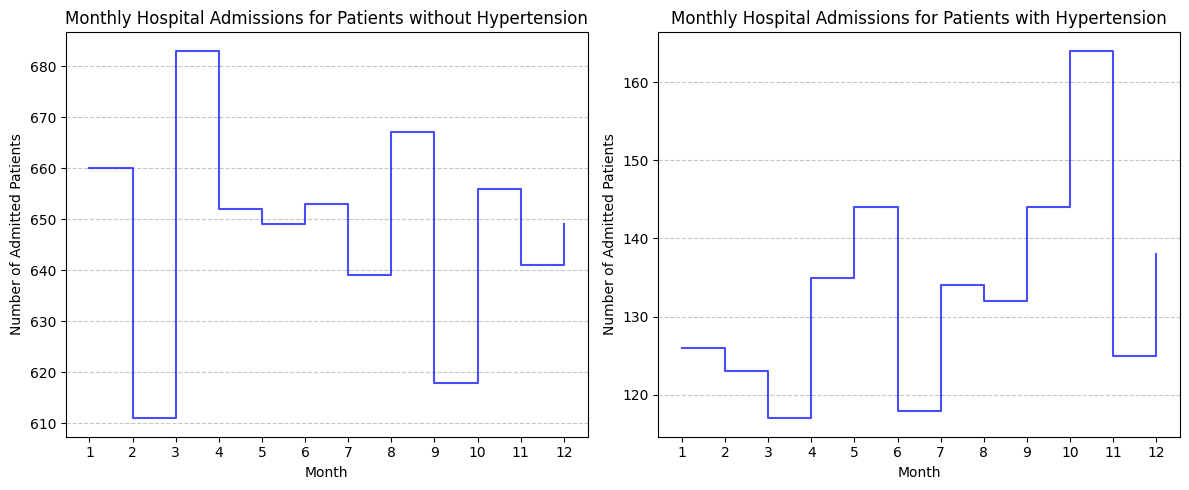

In [13]:
# Note: y-axis does not start at 0

plt.figure(figsize=(12, 5))

# admitted patients without hypertension
plt.subplot(1, 2, 1)
doy_frequency = filtered_df['Date of Admission'][filtered_df.Hypertension == 0].apply(lambda x: x.month).value_counts().sort_index(ascending=True)
plt.step(doy_frequency.index, doy_frequency.values, where='post', color='blue', alpha=0.7)
plt.xticks(range(1, 13))
plt.title('Monthly Hospital Admissions for Patients without Hypertension')
plt.xlabel('Month')
plt.ylabel('Number of Admitted Patients')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# admitted patients with hypertension
plt.subplot(1, 2, 2)
doy_frequency = filtered_df['Date of Admission'][filtered_df.Hypertension == 1].apply(lambda x: x.month).value_counts().sort_index(ascending=True)
plt.step(doy_frequency.index, doy_frequency.values, where='post', color='blue', alpha=0.7)
plt.xticks(range(1, 13))
plt.title('Monthly Hospital Admissions for Patients with Hypertension')
plt.xlabel('Month')
plt.ylabel('Number of Admitted Patients')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


TEMPorary Conclusion of graphs:

In the graph depicting the number of patients admitted to the hospital for Hypertension, the two months following the end of March (considering that daylight saving time starts on the last Sunday of March) exhibit higher admission counts compared to the preceding months. On the other hand, when examining all admissions irrespective of medical conditions, the month of February shows significantly fewer admissions. However, January displays admission counts similar to those observed in the months immediately following the end of March.

<Axes: xlabel='Month'>

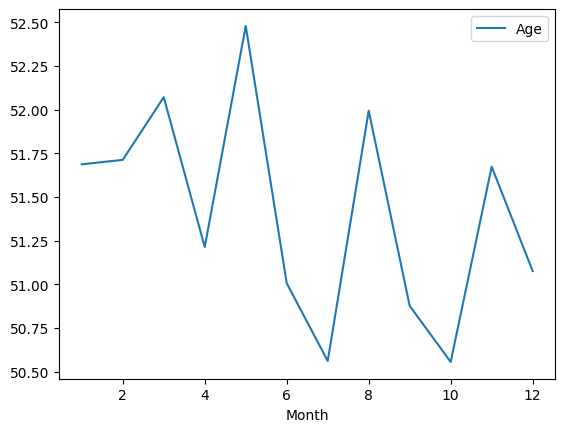

In [14]:
# temporary: check age over months
tempdf = filtered_df.copy()
tempdf['Month'] = filtered_df['Date of Admission'].apply(lambda x: x.month)

tempdf.groupby(['Month']).agg({'Age':'mean'}).plot()


In [15]:
for col_name in filtered_df.columns:
    print(col_name)

Age
Gender
Blood Type
Date of Admission
Insurance Provider
Billing Amount
Admission Type
Medication
Test Results
Hypertension
daylight_saving_march
daylight_saving_before_march


We can already form some hypothesis. We can motivate to follow this work in this case.

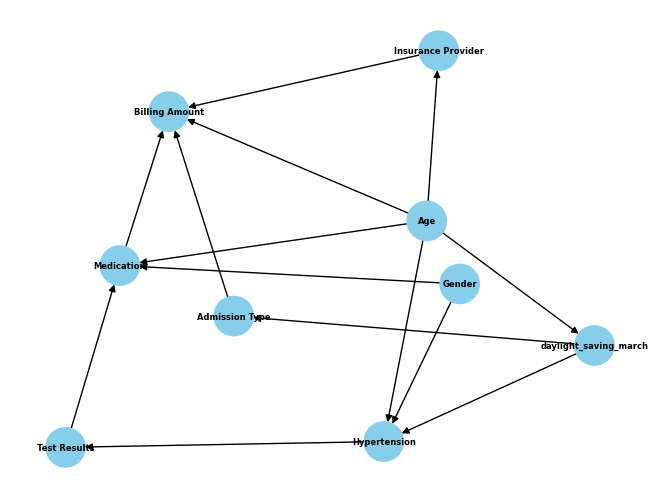

In [17]:
graph_variables = ['Age', 'Gender', 'Insurance Provider', 'Billing Amount', 
                   'Admission Type', 'Medication', 'Test Results', 'Hypertension', 'daylight_saving_march'] #, 'Arthritis', 'Asthma', 'Cancer', 'Diabetes', 'Obesity',]

G = nx.DiGraph()
G.add_nodes_from(graph_variables)

edges = [
    ('Insurance Provider', 'Billing Amount'),       # decides the billing amount
    ('Age', 'Billing Amount'),                      # older people require more care for same treatment
    ('Age', 'Insurance Provider'),                  # marketing or preference by age
    ('Age', 'Hypertension'),                        # blood pressure rises and likelihood of hypertension 
    ('Age', 'Medication'),                          # older people might get different medication
    ('Gender', 'Hypertension'),                     # hormonal reasons maybe influnece the likelihood of hypertension
    ('Gender', 'Medication'),                       # not all medicine apply to men or women
    ('Hypertension', 'Test Results'),           
    ('Test Results', 'Medication'),
    ('Medication', 'Billing Amount'),               # billing amount is dependent on the prescribed medication
    ('daylight_saving_march', 'Hypertension'),      # hypothesis: due to lack of sleep
    ('Admission Type', 'Billing Amount'),           # emerGgency requires more money
    ('daylight_saving_march', 'Admission Type'),    # ?? the period after spring DST effects the number of emergencies etc.
    ('Age', 'daylight_saving_march'),               # ?? confounder: see explanation below
]


G.add_edges_from(edges)

pos = nx.kamada_kawai_layout(G)
node_size = [800 if node in graph_variables else 200 for node in G.nodes]
node_color = ['skyblue' if node in graph_variables else 'lightgray' for node in G.nodes]

nx.draw(G, pos, with_labels=True, font_size=6, node_size=node_size, node_color=node_color, font_color='black', font_weight='bold', arrowsize=10)

plt.tight_layout()
plt.show()

In [18]:
# Check for cycles
list(nx.simple_cycles(G))

daylight_saving_march is 1 if admission day is within x months after spring DST, else 0. So this indicates a period in which patients are admitted, similarly
age influneces if patients are admitted in certain months. For example by the temperature differences which influence for example asthma admissions or hypertension admissions. 

# Exploratory Data Analysis - 15% of the grade

Testing correlations/conditional independences (15% grade, follow Tutorial 1&2)

## Independence tests

In [19]:
from itertools import permutations
import pingouin as pg

def test_all(df, vars):
    # Marginal
    for var1, var2 in permutations(vars, 2):
        p_val = pg.partial_corr(data=df, x=var1, y=var2, covar=[], method='pearson')['p-val'].item()
        print('{} and {}: p-value is {}'.format(var1, var2, p_val))

    # Conditional
    for var1, var2, cond in permutations(vars, 3):
        p_val = pg.partial_corr(data=df, x=var1, y=var2, covar=[cond], method='pearson')['p-val'].item()
        print('{} and {} given {}: p-value is {}'.format(var1, var2, cond, p_val))

In [20]:
def encode_categoricals(df):
    from sklearn.preprocessing import LabelEncoder

    label_encoder = LabelEncoder()

    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = label_encoder.fit_transform(df[column])
            
    return df

In [21]:
# in order to have the partial_corr independence test work we need to have numericals => encode categorical data
df_encoded = encode_categoricals(filtered_df)
df_encoded

,Age,Gender,Blood Type,Date of Admission,Insurance Provider,Billing Amount,Admission Type,Medication,Test Results,Hypertension,daylight_saving_march,daylight_saving_before_march
0,81,0,7,2022-11-17,3,37490.983364,0,0,1,0,0,0
1,35,1,6,2023-06-01,4,47304.064845,1,2,2,0,0,0
2,61,1,5,2019-01-09,3,36874.896997,1,2,2,0,0,0
3,49,1,5,2020-05-02,3,23303.322092,2,4,0,0,0,0
4,51,1,7,2021-07-09,4,18086.344184,2,3,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,83,1,0,2022-07-29,4,39606.840083,0,1,0,0,0,0
9996,47,0,2,2022-01-06,1,5995.717488,1,1,2,0,0,0
9997,54,1,5,2022-07-01,1,49559.202905,0,1,2,0,0,0
9998,84,1,0,2020-02-06,4,25236.344761,2,4,2,0,0,0


In [22]:
test_all(df_encoded, graph_variables)

Age and Gender: p-value is 0.5118936213292858
Age and Insurance Provider: p-value is 0.930665278923154
Age and Billing Amount: p-value is 0.38770579907837377
Age and Admission Type: p-value is 0.5411272036726898
Age and Medication: p-value is 0.3815011637742175
Age and Test Results: p-value is 0.3908643552750751
Age and Hypertension: p-value is 0.14125179220420808
Age and daylight_saving_march: p-value is 0.7324981138165215
Gender and Age: p-value is 0.5118936213292858
Gender and Insurance Provider: p-value is 0.05167704764915217
Gender and Billing Amount: p-value is 0.6399470393661836
Gender and Admission Type: p-value is 0.902025690052402
Gender and Medication: p-value is 0.5923715947692103
Gender and Test Results: p-value is 0.4194962861873397
Gender and Hypertension: p-value is 0.31032412828410527
Gender and daylight_saving_march: p-value is 0.7485748911784491
Insurance Provider and Age: p-value is 0.930665278923154
Insurance Provider and Gender: p-value is 0.05167704764915217
Insu

Age and Medication given Gender: p-value is 0.3795382993160644
Age and Medication given Insurance Provider: p-value is 0.38126946534388984
Age and Medication given Billing Amount: p-value is 0.3892326737216957
Age and Medication given Admission Type: p-value is 0.37880517731599983
Age and Medication given Test Results: p-value is 0.375711576371317
Age and Medication given Hypertension: p-value is 0.38038002562743634
Age and Medication given daylight_saving_march: p-value is 0.37771713036093635
Age and Test Results given Gender: p-value is 0.3938889432561975
Age and Test Results given Insurance Provider: p-value is 0.39126660184973916
Age and Test Results given Billing Amount: p-value is 0.39564469460490626
Age and Test Results given Admission Type: p-value is 0.3874404602258863
Age and Test Results given Medication: p-value is 0.3848718968697551
Age and Test Results given Hypertension: p-value is 0.4020857707339299
Age and Test Results given daylight_saving_march: p-value is 0.39150350

## Interpretation on Results

We expect to get significant p-values for all tests where the graph implies dependece between the variables. We list below some significant conclusions on the p-value.

### Independences

From the independence tests we can notice the low p-values which are below 0.1 the following imply independence:

- gender and insurance provider on their own, but also conditioning on any variable, also accoring to the graph

Gender and Insurance Provider: p-value is 0.05167704764915217

- insurance provider and billing amount, however in the graph we decided there should be some dependence.

Insurance Provider and Billing Amount: p-value is 0.0820549226831016

- Insurance provider is also independent from gender, also according to our graph

Insurance Provider and Gender: p-value is 0.05167704764915217

- medication and daylight saving march, not according with our graph because there is a direct path between the two variables: daylight_saving_march --> Hypertension --> Test Results --> Medication

Medication and daylight_saving_march: p-value is 0.05260410622578935

### Dependences

The high p-values show us the dependence between the variables:
- also according to our graph, there is a high dependence between insurance provider and age

Insurance Provider and Age: p-value is 0.930665278923154


- Insurance Provider and medication are dependent because they are cofounded by Age, also according to our graph

Insurance Provider and Medication: p-value is 0.6086810195977133

- Hypertension is highly dependent on Insurance Provider, also a conclusion aligning with our graph

Insurance Provider and Hypertension: p-value is 0.9939665403739955

- Tests Result is highly correlated with daylight saving, also according to our graph. Test Result seems to be dependent on all the variables, this is also reflected in the graph we came up with which seems great.

Test Results and daylight_saving_march: p-value is 0.7507855125977744

- Billing amount is dependent on gender, not accordyng to our graph.

Billing Amount and Gender: p-value is 0.6399470393661836

## Modifications of the graph after the independence tests

Given the results form the independence tests, we will make the following modifications in our graph:

- Insurance provider will not directly affect billing amount
- insurance provider directly influences hypertension, and age is a confounder for the two
- add an arrow between billing amount and gender
- we eliminate medication and test results as nodes because they might be time dependent (is the medication taken after the test results)

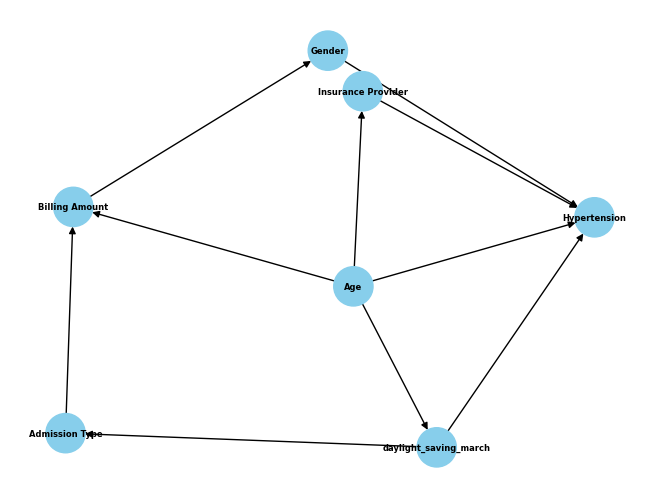

In [23]:
graph_variables = ['Age', 'Gender', 'Insurance Provider', 'Billing Amount', 
                   'Admission Type', 'Hypertension', 'daylight_saving_march'] #, 'Arthritis', 'Asthma', 'Cancer', 'Diabetes', 'Obesity',]

G = nx.DiGraph()
G.add_nodes_from(graph_variables)

edges = [
    ('Age', 'Billing Amount'),                      # older people require more care for same treatment
    ('Age', 'Insurance Provider'),                  # marketing or preference by age
    ('Age', 'Hypertension'),                        # blood pressure rises and likelihood of hypertension 
    ('Gender', 'Hypertension'),                     # hormonal reasons maybe influnece the likelihood of hypertension
    ('daylight_saving_march', 'Hypertension'),      # hypothesis: due to lack of sleep
    ('Admission Type', 'Billing Amount'),           # emerGgency requires more money
    ('daylight_saving_march', 'Admission Type'),    # ?? the period after spring DST effects the number of emergencies etc.
    ('Age', 'daylight_saving_march'),               # ?? confounder: see explanation below
    ('Insurance Provider', 'Hypertension'),        # independence test modification
    ('Billing Amount', 'Gender')
]


G.add_edges_from(edges)

pos = nx.kamada_kawai_layout(G)
node_size = [800 if node in graph_variables else 200 for node in G.nodes]
node_color = ['skyblue' if node in graph_variables else 'lightgray' for node in G.nodes]

nx.draw(G, pos, with_labels=True, font_size=6, node_size=node_size, node_color=node_color, font_color='black', font_weight='bold', arrowsize=10)
nx.write_gml(G, "causal_graph.gml")

plt.tight_layout()
plt.show()

In [24]:
# Check for cycles
list(nx.simple_cycles(G))

# Identify estimands for backdoor, frontdoor criterion and IVs - 20% of the grade

## Finding all paths between ```daylight_saving_march``` and ```Hypertension```

Number of paths found: 7


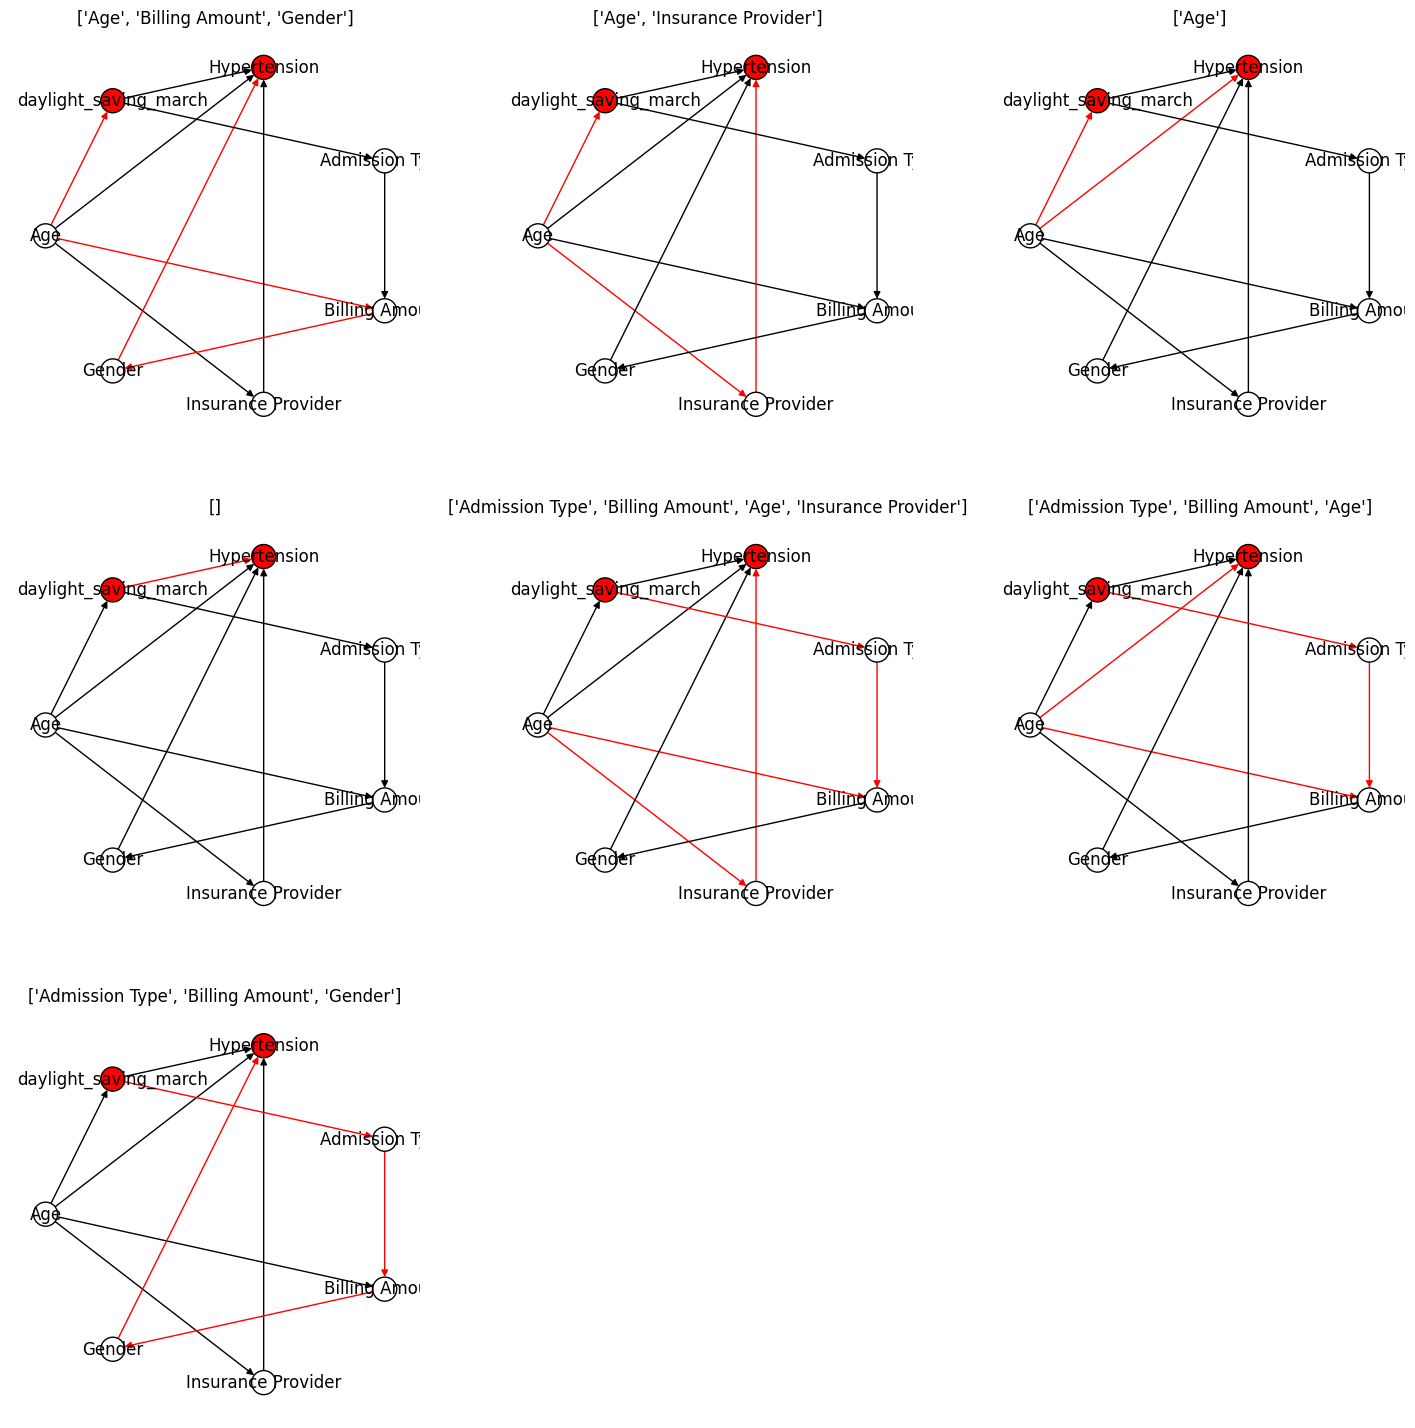

In [25]:
all_paths = list(nx.all_simple_paths(G.to_undirected(), source='daylight_saving_march', target='Hypertension'))
print('Number of paths found:', len(all_paths))

if len(all_paths) > 20:
    all_paths = all_paths[:20]
    
n_cols = 3
n_rows = (len(all_paths) - 1) // n_cols + 1
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 6 * n_rows))

for i, path in enumerate(all_paths):
    col = i % n_cols
    row = i // n_cols
    edges_on_path = [set([source, target]) for source, target in zip(path[:-1], path[1:])]
    edge_color = ['r' if set(edge) in edges_on_path else 'black' for edge in G.edges()]  
    nx.draw_shell(G, with_labels=True, node_color=['w' if i < len(graph_variables) - 2 else 'r' for i in range(len(graph_variables))], edgecolors='black', ax=axs[row, col], edge_color=edge_color)
    axs[row, col].set_title(path[1:-1])
    
# hide empty plots
for i in range(len(all_paths), n_rows * n_cols):
    axs.flatten()[i].axis('off')

Daylight saving martch and hypertension are not d-separated because they have a direct connection.

### Backdoor Criterion

The backdoor criterion allows us to identify the variables on which we need to condition to calculate our causal estimates. We identify these variables by looking at 'backdoor' paths from ```daylight_saving_march``` and ```Hypertension```. We can apply the backdoor criterion here because there are arrows that go into our treatment, ```daylight_saving_march```, and many confounder on the way for which we need to adjust.


INFO:dowhy.causal_model:Model to find the causal effect of treatment ['daylight_saving_march'] on outcome ['Hypertension']


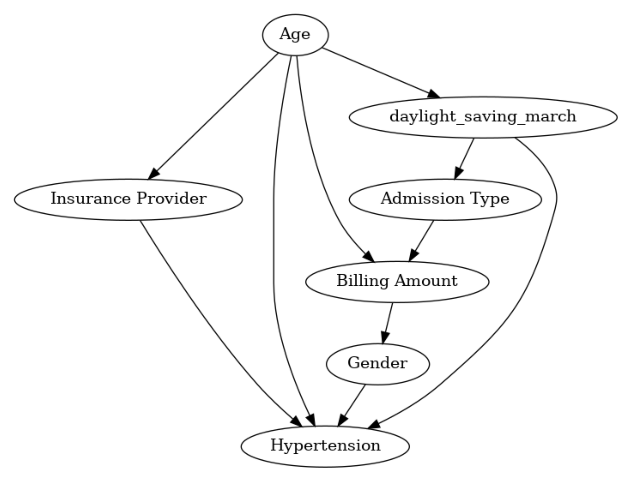

In [26]:
from dowhy import CausalModel

# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

gml_graph = gml_to_string('causal_graph.gml')
# With GML string
model=CausalModel(
    data = df_encoded,
    treatment='daylight_saving_march', 
    outcome='Hypertension',
    graph=gml_graph
)
model.view_model()

In [27]:
# importing the backdoor class from DoWhy
from dowhy.causal_identifier import backdoor

df_encoded.head()

# creating a copy of our graph G that is undirected
H = G.to_undirected()
# all_possible_paths = list(nx.all_simple_paths(H, 'daylight_saving_march', 'Hypertension'))
bd = backdoor.Backdoor(G, 'daylight_saving_march','Hypertension')
backdoor_paths = [path for path in all_paths if bd.is_backdoor(path)]

#### Visualization of backdoor paths

Number of backdoor paths found: 3


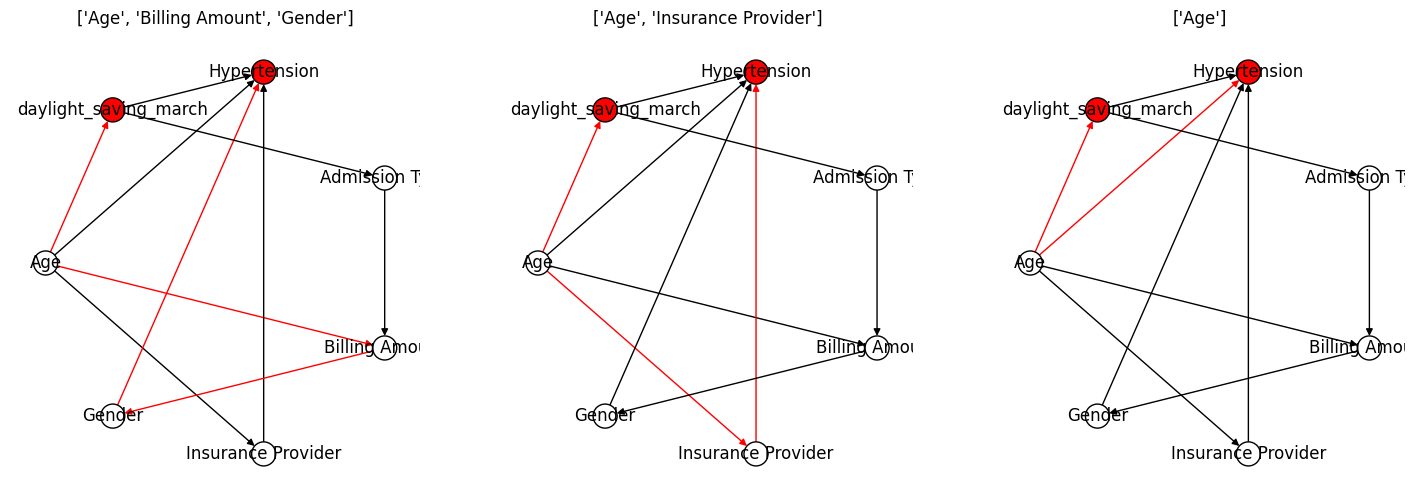

In [28]:
# we apply the is_backdoor function to each path to check if a path is a backdoor path

print('Number of backdoor paths found:', len(backdoor_paths))

if len(backdoor_paths) > 20:
    backdoor_paths = backdoor_paths[:20]
    
n_cols = 3
n_rows = (len(backdoor_paths) - 1) // n_cols + 1
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 6 * n_rows))

for i, path in enumerate(backdoor_paths):
    col = i % n_cols
    row = i // n_cols
    edges_on_path = [set([source, target]) for source, target in zip(path[:-1], path[1:])]
    edge_color = ['r' if set(edge) in edges_on_path else 'black' for edge in G.edges()]  
    nx.draw_shell(G, with_labels=True, node_color=['w' if i < len(graph_variables) - 2 else 'r' for i in range(len(graph_variables))], edgecolors='black', ax=axs[col], edge_color=edge_color)
    axs[col].set_title(path[1:-1])
    
# hide empty plots
for i in range(len(backdoor_paths), n_rows * n_cols):
    axs.flatten()[i].axis('off')

We find three backdoor paths between our treatment and the outcome. Let's analyse what we need to adjust for.

In [29]:
adjustment_variables = pd.DataFrame(columns=['path', 'colliders', 'non_colliders'])

In [30]:
for path in backdoor_paths:
    colliders = np.array([])
    non_colliders = []
    path_len = len(path)

    # we loop through adjacent variables on the path, ignoring the source and target variables as potential colliders
    for node0, node1, node2 in zip(path[0:path_len-2], path[1:path_len-1], path[2:]):
        # if there is an arrow pointing into node1 from both sides on the path, it is a collider
        if G.has_edge(node0, node1) and G.has_edge(node2, node1):
            colliders = np.append(colliders, list(nx.descendants(G,node1)) + [node1]) # so we add it (and all its descendants) to the list
    # we flatten the list of list
    colliders = colliders.flatten()

    # any node on the path (excluding the source and target) that is not a collider is a non-collider
    non_colliders = [x for x in path[1:-1] if x not in colliders]

    # finally, we add the information to our dataframe, with the path, colliders, and non-colliders
    adjustment_variables.loc[len(adjustment_variables.index)] = [path, colliders, non_colliders] 

In [31]:
adjustment_variables

,path,colliders,non_colliders
0,"[daylight_saving_march, Age, Billing Amount, G...",[],"[Age, Billing Amount, Gender]"
1,"[daylight_saving_march, Age, Insurance Provide...",[],"[Age, Insurance Provider]"
2,"[daylight_saving_march, Age, Hypertension]",[],[Age]


There are no colliders on any of the backdoor paths. We need to condition on at least one common non-collider from the three paths found, which are not in the collider set. Therefore, we need to condition on ```Age``` to block all backdoor paths from our treatment ```daylight_saving_march``` to our outcome ```Hypertension```.

### Frontdoor Criterion

We want to also apply the frontdoor criterion. We want to find the adjustment set which satisfies the frontdoor criterion. First of all we need to get all directed paths from ```daylight_saving_march``` and ```Hypertension```.

In [32]:
our_causal_graph = model._graph
our_causal_graph.get_all_directed_paths(["daylight_saving_march"], ["Hypertension"])

[['daylight_saving_march', 'Hypertension'],
 ['daylight_saving_march',
  'Admission Type',
  'Billing Amount',
  'Gender',
  'Hypertension']]

Because there is a direct edge between our treatment and our outcome, we cannot apply the frontdoor criterion. The adjustment set able to satiisfy this criterion needs to intercent all directed patch from ```daylight_saving_march``` and ```Hypertension``` and because of the direct edge between the two variables, such an adjustment set does not exist.

### Instrumental Variables

We believe there is an unobserved confounder, ```sleep_quality```, between ```daylight_saving_march``` and ```Hypertension``` because one less hour of sleep could directly affect the hypertension risks and the date of admission to the hospital.

The only measure that we have which could influece the date of admission (implicitly ```daylight_saving_march```) is ```Age```. Depending on age, people have different routines during the year, moments where stress is higher, or they simply have a higher risk of getting a heart attack.

However, ```Age``` cannot be part of the adjustment set for the Instrumental Variables criterion because it has a direct effect on ```Hypertension```. Therefore, there are no variables found to adjust for the iv.

### DoWhy Check

In [33]:
identified_estimand = model.identify_effect()
print(identified_estimand)

identifier = model.identifier
identifier.identify_backdoor(model._graph, model._treatment, model._outcome)

INFO:dowhy.causal_identifier.auto_identifier:Causal effect can be identified.
INFO:dowhy.causal_identifier.auto_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier.auto_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                 
────────────────────────(E[Hypertension|Age])
d[daylight_saving_march]                     
Estimand assumption 1, Unconfoundedness: If U→{daylight_saving_march} and U→Hypertension then P(Hypertension|daylight_saving_march,Age,U) = P(Hypertension|daylight_saving_march,Age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



[{'backdoor_set': ('Age', 'Insurance Provider')}, {'backdoor_set': ('Age',)}]

Indeed, we need to adjust for ```Age``` to block all the backdoor paths. There is no adjustment set found for the frontdoor criterion or the instrumental variables criterion.

# Estimate the causal effects

Given our reasoning from the previous section, we know that we have to condition on ```Age``` to get the true effect of ```daylight_saving_march``` on ```Hypertension```. We apply different estimators from the DoWhy package.

#### Linear Estimator

In [34]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

INFO:dowhy.causal_model:linear_regression
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Hypertension~daylight_saving_march+Age+daylight_saving_march*Insurance Provider


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                 
────────────────────────(E[Hypertension|Age])
d[daylight_saving_march]                     
Estimand assumption 1, Unconfoundedness: If U→{daylight_saving_march} and U→Hypertension then P(Hypertension|daylight_saving_march,Age,U) = P(Hypertension|daylight_saving_march,Age)

## Realized estimand
b: Hypertension~daylight_saving_march+Age+daylight_saving_march*Insurance Provider
Target units: ate

## Estimate
Mean value: -0.028942081902811584

Causal Estimate is -0.028942081902811584


In [35]:
# Textual Interpreter
causal_estimate.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [daylight_saving_march] from 0 to 1 causes an increase of -0.028942081902811584 in the expected value of the outcome [['Hypertension']], over the data distribution/population represented by the dataset.


With a linear estimator we have a causal effect of -0.02849093. We can see that maybe a linear estimator is not the best to apply. We might think that the true nature of our effect and the assumptions made by the estimator do not match entirely. We would expect for a positive causal estimate effect of the ```daylight_saving_march``` and ```Hypertension```. We therefore apply one more estimate

#### Propensity Score Stratification

In [36]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="att")
print(causal_estimate_strat)
print("Causal Estimate is " + str(causal_estimate_strat.value))

INFO:dowhy.causal_model:propensity_score_stratification
INFO:dowhy.causal_estimator:Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: Hypertension~daylight_saving_march+Age
INFO:dowhy.causal_estimator:'num_strata' selected as 468.9
INFO:dowhy.causal_estimator:No strata found with at least 10 data points. Selecting fewer number of strata
INFO:dowhy.causal_estimator:'num_strata' selected as 234
INFO:dowhy.causal_estimator:No strata found with at least 10 data points. Selecting fewer number of strata
INFO:dowhy.causal_estimator:'num_strata' selected as 117
INFO:dowhy.causal_estimator:No strata found with at least 10 data points. Selecting fewer number of strata
INFO:dowhy.causal_estimator:'num_strata' selected as 58
INFO:dowhy.causal_estimator:Less than half the strata have at least 10 data points. Selecting fewer number of strata.
INFO:dowhy.causal_estimator:'num_strata' selected as 29
INFO:dowhy.causal_estimator:Less than half the strata have at least 10 dat

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                 
────────────────────────(E[Hypertension|Age])
d[daylight_saving_march]                     
Estimand assumption 1, Unconfoundedness: If U→{daylight_saving_march} and U→Hypertension then P(Hypertension|daylight_saving_march,Age,U) = P(Hypertension|daylight_saving_march,Age)

## Realized estimand
b: Hypertension~daylight_saving_march+Age
Target units: att

## Estimate
Mean value: -0.028116028011328436

Causal Estimate is -0.028116028011328436


In [37]:
# Textual Interpreter
interpretation = causal_estimate_strat.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [daylight_saving_march] from 0 to 1 causes an increase of -0.028116028011328436 in the expected value of the outcome [['Hypertension']], over the data distribution/population represented by the dataset.


#### Propensity Score Matching

In [38]:
causal_estimate_match = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units="atc")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

INFO:dowhy.causal_model:propensity_score_matching
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: Hypertension~daylight_saving_march+Age


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                 
────────────────────────(E[Hypertension|Age])
d[daylight_saving_march]                     
Estimand assumption 1, Unconfoundedness: If U→{daylight_saving_march} and U→Hypertension then P(Hypertension|daylight_saving_march,Age,U) = P(Hypertension|daylight_saving_march,Age)

## Realized estimand
b: Hypertension~daylight_saving_march+Age
Target units: atc

## Estimate
Mean value: 0.004616399208617278

Causal Estimate is 0.004616399208617278


In [39]:
# Textual Interpreter
interpretation = causal_estimate_match.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [daylight_saving_march] from 0 to 1 causes an increase of 0.004616399208617278 in the expected value of the outcome [['Hypertension']], over the data distribution/population represented by the dataset.


We notice that we finally get a positive effect of the ```daylight_saving_march``` on ```Hypertension``` when using a propensity score matching. Weirdly enough, when the data is startified and using a propensity score we get a causal effect of -0.028. When match units in data instead we obtain a positive causal effect 0.00461.

# Finding the Causal Graph with Causal Discovery

#### Obtain skeleton of graph

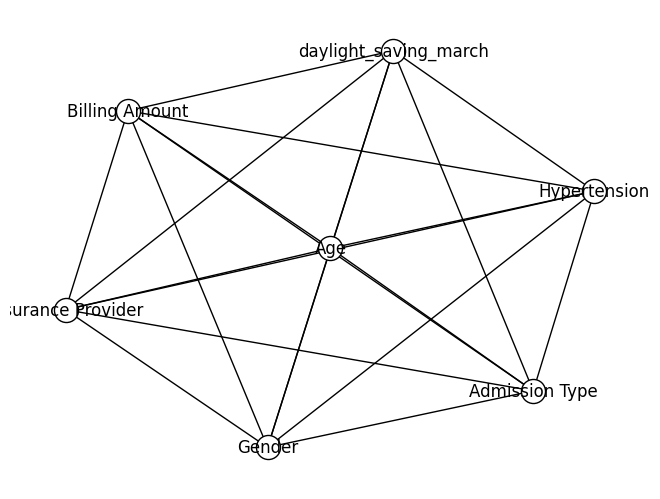

In [40]:
nodes =  graph_variables
skeleton = nx.Graph()
skeleton.add_nodes_from(nodes)
skeleton.add_edges_from(combinations(nodes, 2))

nx.draw(skeleton, with_labels=True, node_color='w', edgecolors ='black')

#### Apply independence tests to get the undirected graph

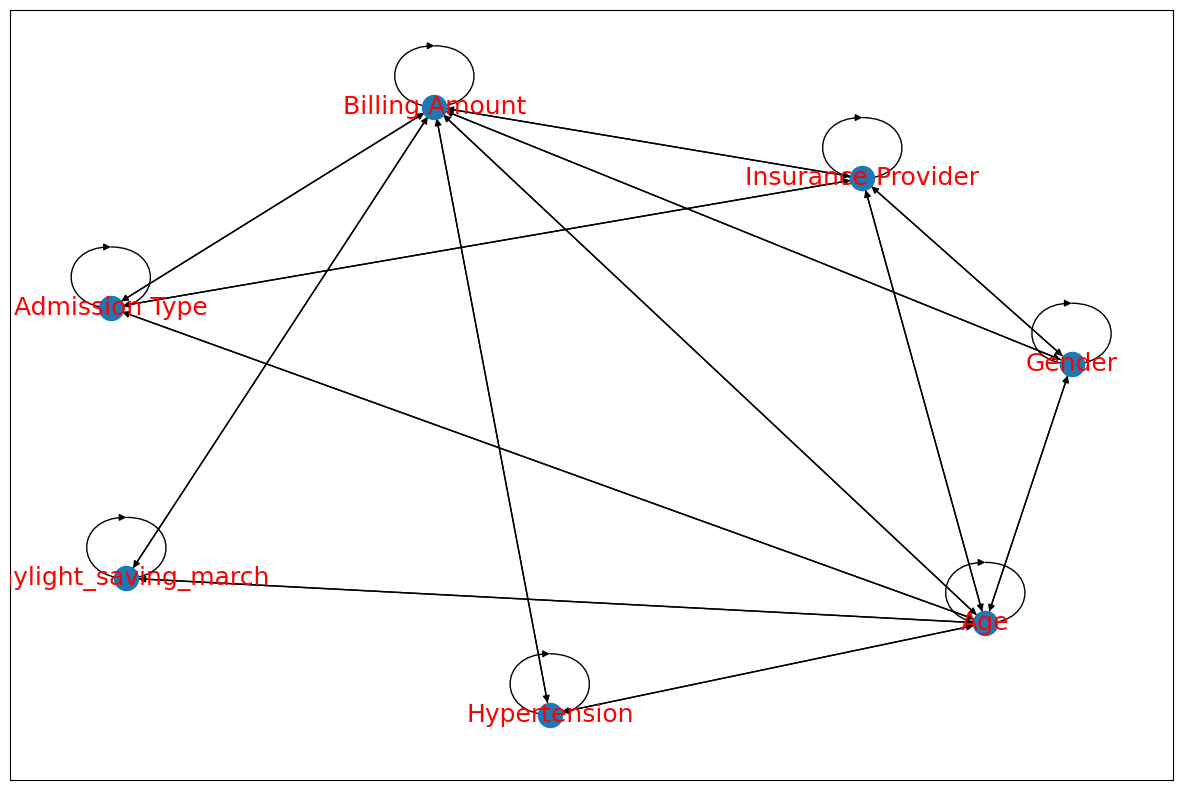

In [41]:
# initialize graph lasso
import cdt

glasso = cdt.independence.graph.Glasso()

# apply graph lasso to data
df = df_encoded[graph_variables]
skeleton = glasso.predict(df) # visualize network
fig = plt.figure(figsize=(15,10))
nx.draw_networkx(skeleton, font_size=18, font_color='r')

Apply PC

In [42]:
pc = cdt.causality.graph.PC(CItest="gaussian", alpha=0.01)

pc_graph = pc.create_graph_from_data(df)
colors = ['red'  if (y,x) in pc_graph.edges() else 'black' for (x,y) in pc_graph.edges()]
nx.draw(pc_graph, with_labels=True, node_size=100, node_color='w', edgecolors ='black', edge_color=colors)

ImportError: R Package (k)pcalg/RCIT is not available. RCIT has to be installed from https://github.com/Diviyan-Kalainathan/RCIT

In [ ]:
pc_graph.edges()

In [ ]:
new_skeleton = cdt.utils.graph.remove_indirect_links(skeleton, alg='aracne')
model = cdt.causality.graph.GES()
output_graph = model.predict(df_encoded, new_skeleton)
print(nx.adjacency_matrix(output_graph).todense())

nx.draw(output_graph, with_labels=True, node_size=100, node_color='w', edgecolors ='black', edge_color=colors)

# Conclusion

Discussion on the assumptions and results